# Gradient Boost Model Improvement
In this notebook, I'll try to improve the model created by Thinkful to predict whether someone lives with a partner or not. For this purpose, I'll use the European Social Survey Data. Our target variable is categorical. The initial model prepared by Thinkful.

In [67]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

In [68]:
# load the dataset
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()
df.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


In [69]:
# set our outcome to 0 and 1.
# define outcome and predictors
df['partner'] = np.where(df['partner'] == 2, 1,0)

y = df['partner']
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# create training and test sets.
offset = int(X.shape[0] * 0.9)

# put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# and put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [88]:
# we'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors*100, train_tII_errors*100, test_tI_errors*100, test_tII_errors*100))

print('\nTrain set accuracy score: ', clf.score(X_train, y_train))
print('Test set accuracy score: ', clf.score(X_test, y_test))

Training set accuracy:
Percent Type I errors: 4.650845608292417
Percent Type II errors: 17.607746863066012

Test set accuracy:
Percent Type I errors: 6.257668711656442
Percent Type II errors: 18.52760736196319

Train set accuracy score:  0.7774140752864157
Test set accuracy score:  0.7521472392638037


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

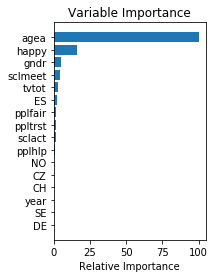

In [72]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### Model Improvement

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement. Strategies I might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

First, let's check the class imbalance in outcome variable to make sure if I need oversampling/undersampling.

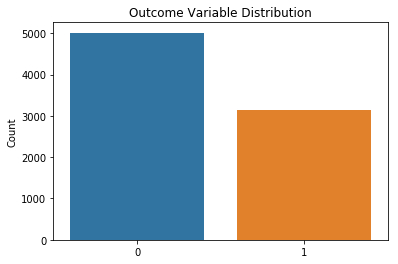

In [73]:
# barplot of outcome varibale
_ = sns.barplot(x=df.partner.unique(), y = df.partner.value_counts())
_.set(title = 'Outcome Variable Distribution', ylabel = 'Count')
plt.show()

It looks like we don't have a class imbalance problem. I want to apply PCA and play with model parameters. To experiment, I'll increase the number of estimators and maximum depth, and use exponential loss function instead of deviance.

Accuracy:
Percent Type I errors: 0.14729348226340983
Percent Type II errors: 3.571866944887689

Accuracy Score: 0.962808395728489


Cross Validation Score Statistics: 0.71499 (+/- 0.03711)


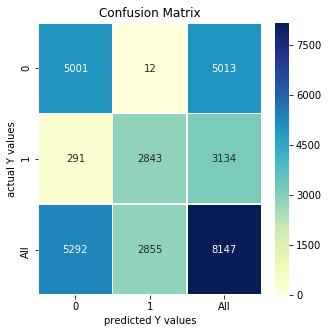

In [84]:
# principal component analysis
pca = PCA(n_components = 7)
data_pca = df.drop('partner', 1)

# convert categorical variables to binary represented features
data_pca = pd.get_dummies(data_pca)
data_pca = pca.fit_transform(data_pca)

# define input and outcome variables
X = data_pca
Y = df.partner

# define parameters
params = {'n_estimators': 1500,
          'max_depth': 4,
          'loss': 'exponential'}

# initialize and fit the model
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X, Y)

# predicted values
Y_ = clf.predict(X)


# accuracy tables.
table_train = pd.crosstab(Y, Y_, margins=True)

tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

print((
    'Accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n').format(tI_errors*100, tII_errors*100))


print('Accuracy Score: ' + str(clf.score(X, Y)) + '\n')

# cross validation
cvs = cross_val_score(clf, X, Y, cv=10)
print("\nCross Validation Score Statistics: %0.5f (+/- %0.5f)" % (cvs.mean(), cvs.std() * 2))


f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(table_train, annot = True,linewidths=0.5, cmap = 'YlGnBu',fmt = ".0f", ax=ax)
plt.title("Confusion Matrix")
plt.xlabel("predicted Y values")
plt.ylabel("actual Y values")
plt.show()

While playing with the model parameters to find the best combination, I noticed that when either the number of estimators or maximum depth increased the model faces overfitting issues. As we can see, accuracy score is high and confusion matrix shows that the percentage of Type I and Type II errors significantly dropped. However, 10 folds cross-validation accuracy mean is very low. Probably, it's better to use GridSearch to find the best possible parameters' combination.

## GridSearchCV 

In [48]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search
param_grid = {
    'min_samples_leaf': [3, 10],
    'min_samples_split': [2, 12],
    'max_depth': [2, 50],
    'n_estimators': [500, 1500],
    'loss': ['exponential', 'deviance'],
    'subsample': [0.1, 1]}

In [49]:
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid,
                           cv=5, n_jobs=2)
grid_search.fit(X, Y)
grid_search.best_params_

{'loss': 'deviance',
 'max_depth': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 12,
 'n_estimators': 500,
 'subsample': 1}

Accuracy:
Percent Type I errors: 3.571866944887689
Percent Type II errors: 17.810236897017305

Accuracy Score: 0.78617896158095


 Cross Validation Score Statistics: 0.74261 (+/- 0.02982)


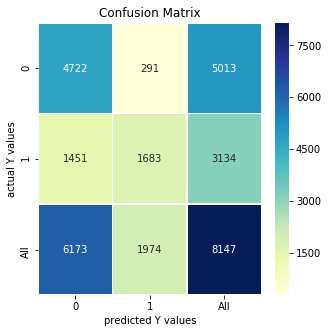

In [87]:
# define parameters
params2 = {'loss': 'deviance',
 'max_depth': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 12,
 'n_estimators': 500,
 'subsample': 1}


# initialize and fit the model
clf = ensemble.GradientBoostingClassifier(**params2)
clf.fit(X, Y)

Y_ = clf.predict(X)

# accuracy tables.
table_acc = pd.crosstab(Y, Y_, margins=True)

tI_errors = table_acc.loc[0.0,1.0] / table_acc.loc['All','All']
tII_errors = table_acc.loc[1.0,0.0] / table_acc.loc['All','All']

print((
    'Accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n').format(tI_errors*100, tII_errors*100))

print('Accuracy Score: ' + str(clf.score(X, Y)) + '\n')
cvs = cross_val_score(clf, X, Y, cv=10)
print("\n Cross Validation Score Statistics: %0.5f (+/- %0.5f)" % (cvs.mean(), cvs.std() * 2))

f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(table_acc, annot = True,linewidths=0.5, cmap = 'YlGnBu',fmt = ".0f", ax=ax)
plt.title("Confusion Matrix")
plt.xlabel("predicted Y values")
plt.ylabel("actual Y values")
plt.show()

## Conclusion
GridSearch helped me to define best parameters' combination to fit the model and get more accurate numbers. I was able to reduce the inaccuracy in Type I errors by 1%. Cross-validation accuracy mean also increased and the standard deviation is not very significant. 